In [208]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [184]:
# load data
df = pd.read_csv("../data/raw_data/online_retail.csv")

In [185]:
# first view of the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [186]:
# shape of the data
df.shape

(541909, 8)

In [187]:
# info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [188]:
# descriptive analysis
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [189]:
# check missing CustomerID
print(df['CustomerID'].isnull().sum()) # 135080 missing values in CustomerID col.

# check missing InvoiceNo
print(df['InvoiceNo'].isnull().sum()) # 0 missing values in InvoiceNo col.

135080
0


In [190]:
# check negative quantities and prices and sum it up
neg_quantities = df[df['Quantity'] < 0]
print(len(neg_quantities)) # 10624 neg quantities

neg_zero_prices = df[df['UnitPrice'] <= 0]
print(len(neg_zero_prices)) # 2517 neg and zero prices collectively

10624
2517


In [191]:
# check number of cancelled invoices
cancelled_invoices = df[df['InvoiceNo'].str.startswith('C')]
print(len(cancelled_invoices)) # 9288 cancelled invoices

9288


In [192]:
# remove all the rows having missing CustomerID, negative quantity, and zero price, and cancelled_invoices

# Remove missing IDs immediately
df = df.dropna(subset=['CustomerID'])

# Combined filter for performance and logic
# Keeps only positive quantity, positive price, and non-cancelled invoices
df = df[
    (df['Quantity'] > 0) & 
    (df['UnitPrice'] > 0) & 
    (~df['InvoiceNo'].str.startswith('C'))
]

# Final polish
df = df.drop_duplicates()

display(df.shape)

(392692, 8)

In [193]:
# As the 'InvoiceDate' is of object type, we need to convert it into Date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
print(df['InvoiceDate'].dtype)

datetime64[ns]


In [194]:
# let's feature engineer the data by adding 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [195]:
# save the df before visualization
df.to_csv("../data/cleaned_data/cleaned_data.csv", index=False)

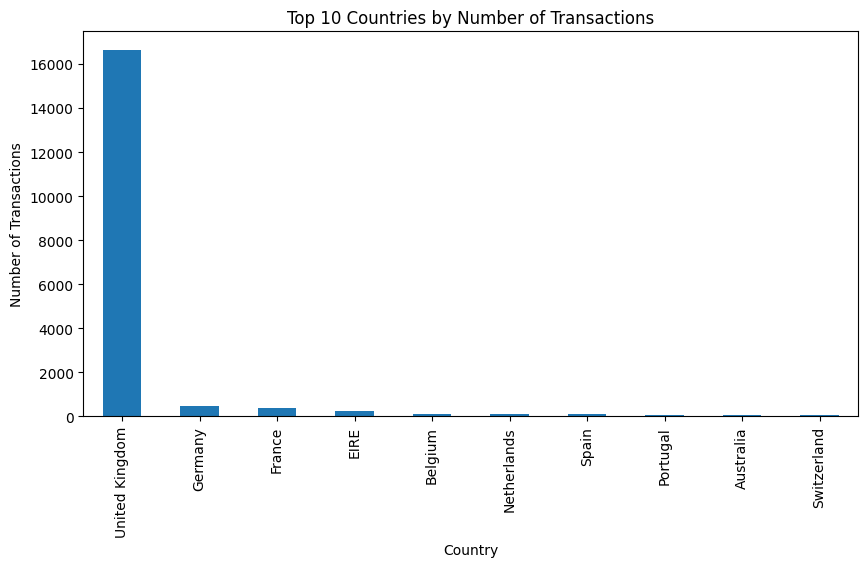

In [196]:
# analyze the transaction volume by country
country_txn = (
    df.groupby('Country')['InvoiceNo']
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
country_txn.plot(kind='bar')
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.show()


### TODO: write the insights of above visualization

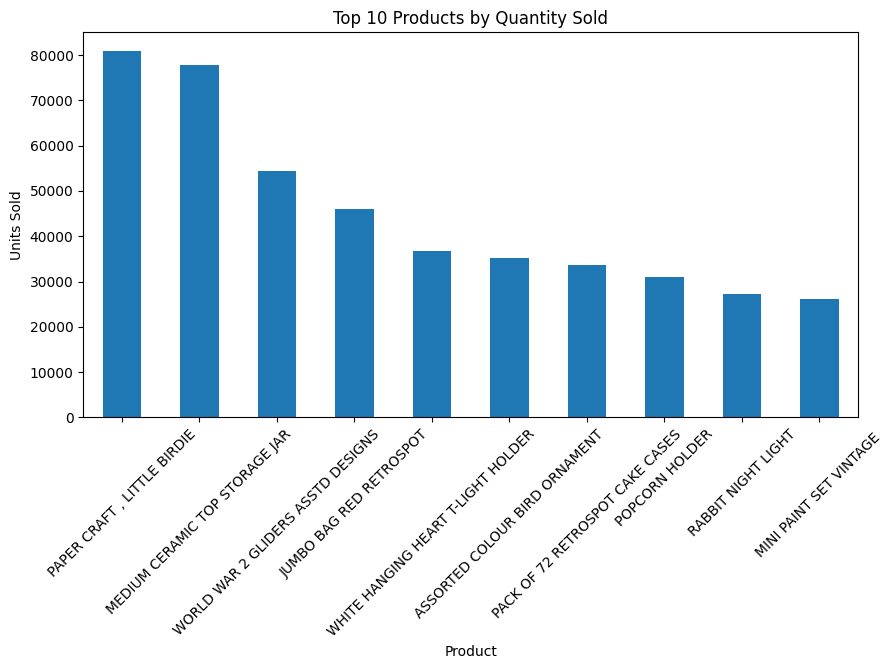

In [197]:
# analyze the top selling products
top_qty_products = (
    df.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_qty_products.plot(kind='bar')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()


### As we have seen above, some products doesn't have any description.

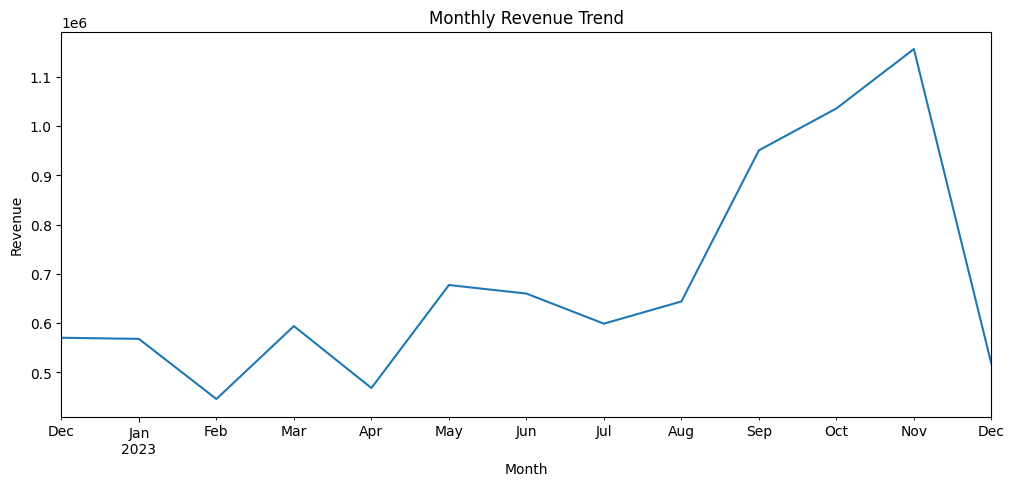

In [198]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')

monthly_revenue = (
    df.groupby('Month')['TotalPrice']
    .sum()
)

plt.figure(figsize=(12,5))
monthly_revenue.plot()
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()


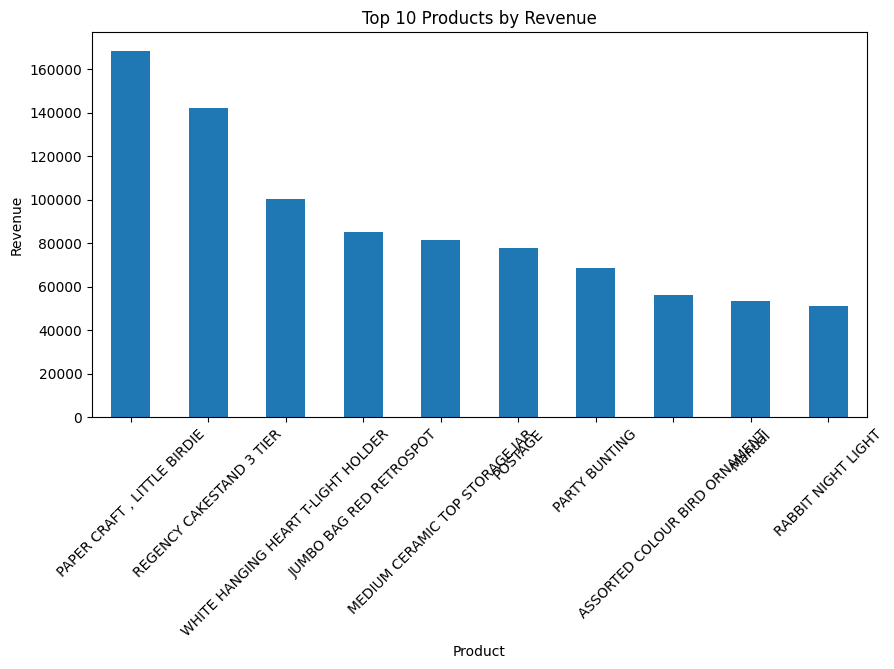

In [199]:
# check top revenue products
top_rev_products = (
    df.groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
top_rev_products.plot(kind='bar')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()


In [200]:
display(df['TotalPrice'])

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: TotalPrice, Length: 392692, dtype: float64

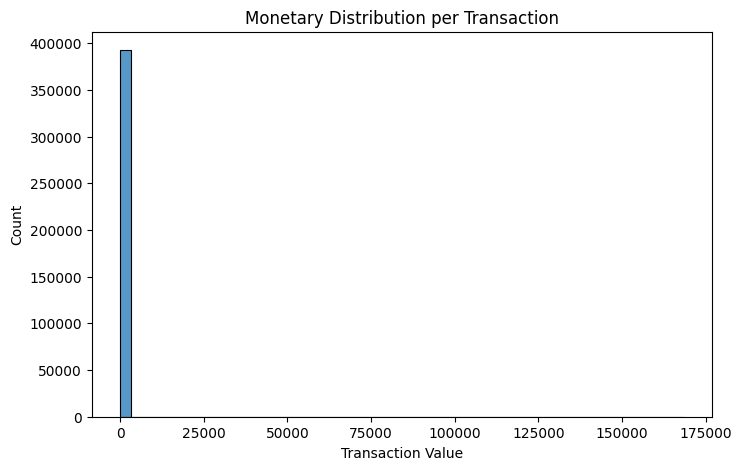

In [201]:
# monetary distribution -> per transaction
plt.figure(figsize=(8,5))
sns.histplot(df['TotalPrice'], bins=50)
plt.title('Monetary Distribution per Transaction')
plt.xlabel('Transaction Value')
plt.show()


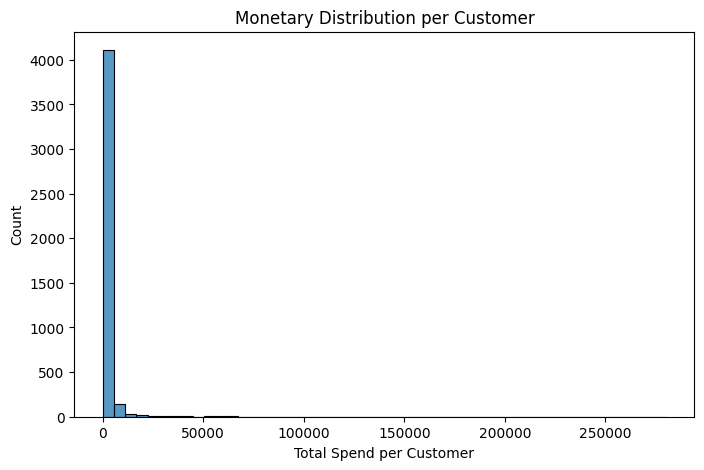

In [202]:
# monetary distribution -> per customer
customer_monetary = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(8,5))
sns.histplot(customer_monetary, bins=50)
plt.title('Monetary Distribution per Customer')
plt.xlabel('Total Spend per Customer')
plt.show()


In [203]:
# RFM distributions
# choose a ref date 
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1) # why add 1day => customers who bought on the last day get Recency = 1, not 0.

# compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


In [207]:
# RFM must be scaled -> for kmeans it is mandatory
scaler =  StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)


In [209]:
# Elbow curve for cluster selection
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
